# Exponential Smoothing

## Kevin Sheppard
### Advanced Financial Econometrics: Forecasting

### Background

Material available on [my site](https://www.kevinsheppard.com/teaching/mfe/advanced-financial-econometrics-forecasting/).

More detail in [pre-recorded lectures](https://www.youtube.com/playlist?list=PLVR_rJLcetzmES8tqjgqlQw1Vx2IKMVot).

### Viewing as a Presentation

This notebook has been written with RISE in mind. To view it as a presentation, install RISE using pip install RISE and then press ALT + R to enter slides model.

### Updating statsmodels

Some of the code in this notebook requires a recent version statsmodels (as of May 2020). If you already have statsmodels 0.12.0 or later, you can ignore this step.

You can install the development version of statsmodels using the command

```
pip install statsmodels --upgrade --pre --find-links https://7933911d6844c6c53a7d-47bd50c35cd79bd838daf386af554a83.ssl.cf2.rackcdn.com/ 
```

This is a repository where pre-release versions are stored.

# Simple Exponential Smoothing

## Random Walk Forecasting

* The basic EWMA, which is known as Simple Exponential Smoothing (SES)
* Defined using the recursion

$$\hat{X}_{T+1|T}=\alpha X_{T}+\left(1-\alpha\right)\hat{X}_{T|T-1}$$

* The first forecast is

$$\hat{X}_{2|1}=\alpha X_{1}+\left(1-\alpha\right)\hat{X}_{1|0}$$

* $\hat{X}_{1|0}$ is an initial value that is not from the data, often set to $X_{1}$
* $\alpha$ (and $X_{1|0}$) is commonly estimated using least squares

# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from scipy import stats
import seaborn as sns
sns.set_style("darkgrid")
# These values are optimized for full-screen on a high-resolution monitor
plt.rc("figure", figsize=(40,16))
plt.rc("font", size=28)
plt.rc("lines", linewidth=4) 

# Load some data

We will use the 432-observation M4 data to explore ES.

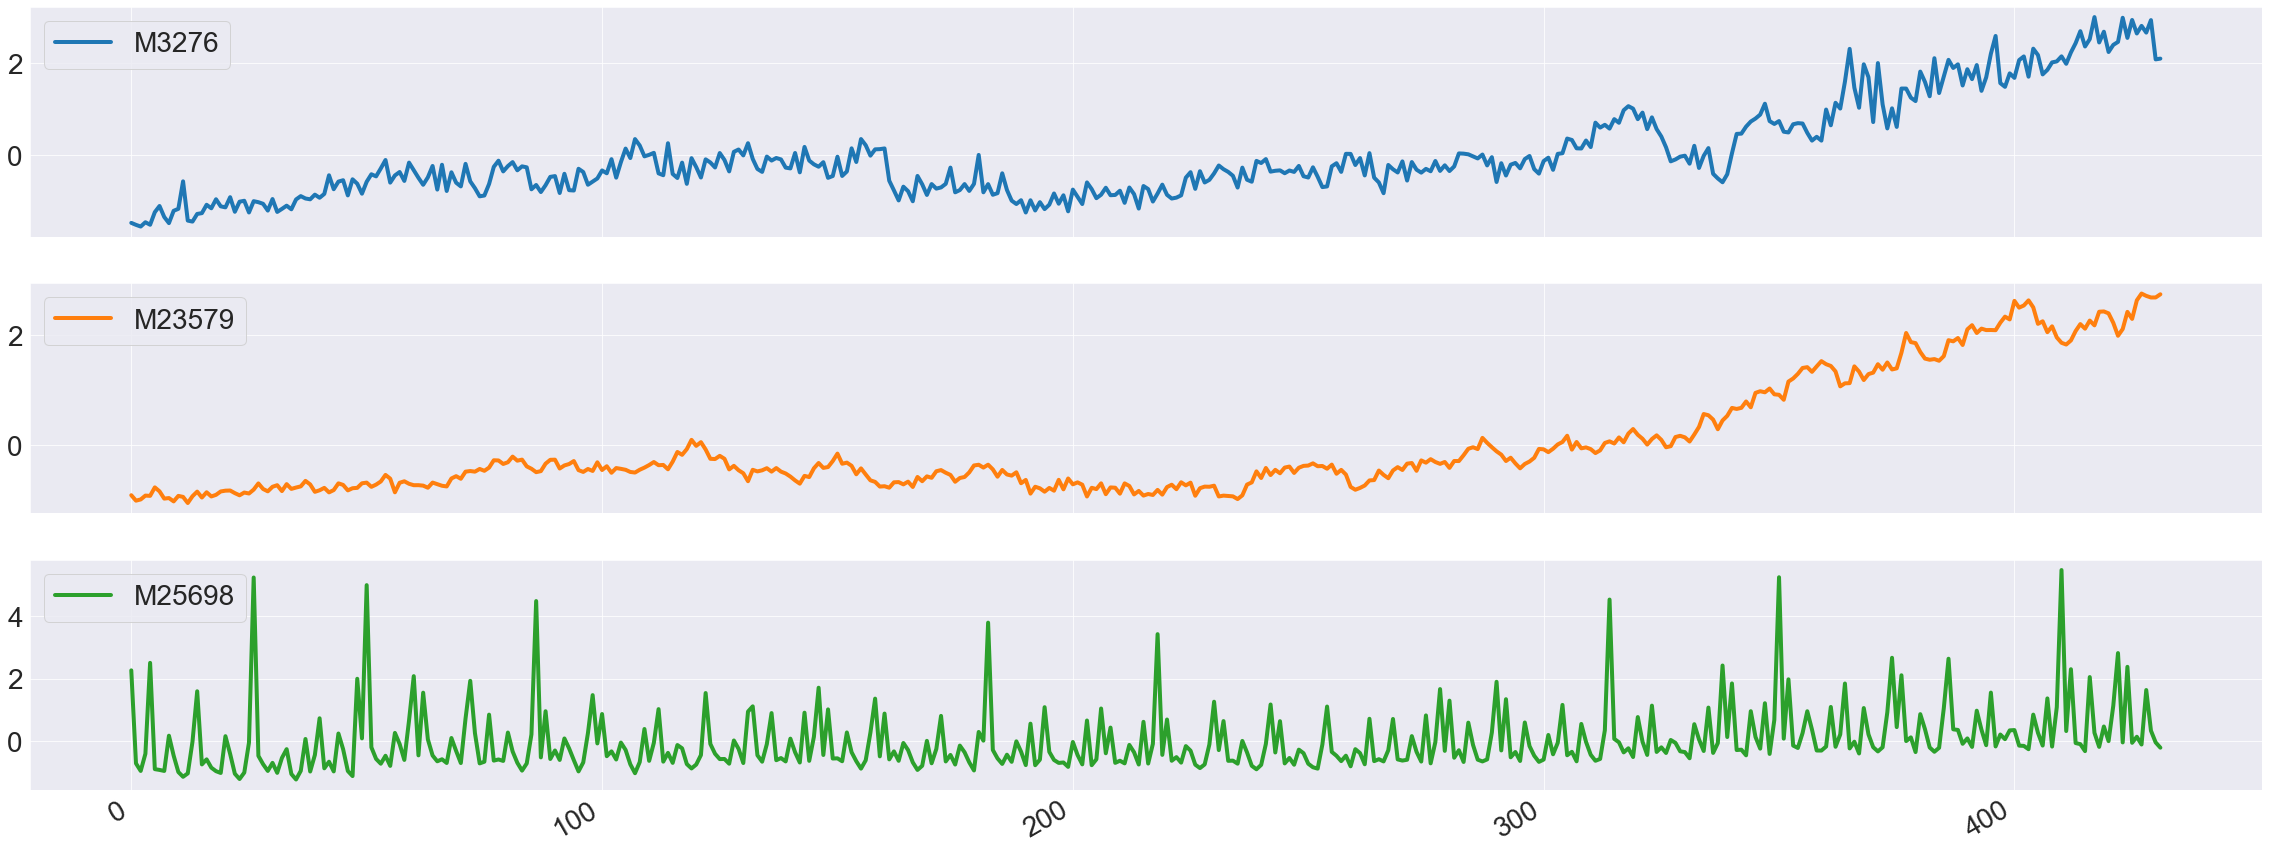

In [2]:
df: pd.DataFrame = pd.read_hdf("./monthly-data.h5", f"nobs_432")
x = df[["M3276","M23579","M25698"]]
x.index = np.arange(x.shape[0])
std_x = (x - x.mean()) / x.std()
plts = std_x.plot(subplots=True)

# SES Example

```
ExponentialSmoothing(endog, trend=False, damped_trend=False, seasonal=None, initialization_method='estimated', initial_level=None, initial_trend=None, initial_seasonal=None, bounds=None, concentrate_scale=True, dates=None, freq=None, missing='none')
```

Key parameters:

* `initial_level`: A value to use for the initial level
* `initialization_method`: One of "estimated", "concentrated", "heuristic" or "known". If "known" initialization is used, then `initial_`$param$ must be passed for the relevant parameters.

See the [full help for details](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.exponential_smoothing.ExponentialSmoothing.html?highlight=exponential_smoothing).

In [3]:
y = x["M3276"]
es = ExponentialSmoothing(y).fit()
es.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:                   ETS(A, N, N)   Log Likelihood               -2140.935
Date:                Wed, 06 May 2020   AIC                           4287.870
Time:                        17:58:56   BIC                           4300.075
Sample:                             0   HQIC                          4292.689
                                - 432   Scale                         1180.696
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4492        nan        nan        nan         nan         nan
initial_level     854.2277        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      227.00   Jarque-Bera (JB):                10.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [4]:
y = x["M3276"]
ses = ExponentialSmoothing(np.log(y)).fit()
ses.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:                   ETS(A, N, N)   Log Likelihood                 874.568
Date:                Wed, 06 May 2020   AIC                          -1743.136
Time:                        17:58:57   BIC                          -1730.931
Sample:                             0   HQIC                         -1738.318
                                - 432   Scale                            0.001
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4504        nan        nan        nan         nan         nan
initial_level       6.7487        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      240.63   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.00   Prob(JB):                         0.70
Heteroskedasticity (H):               1.49   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

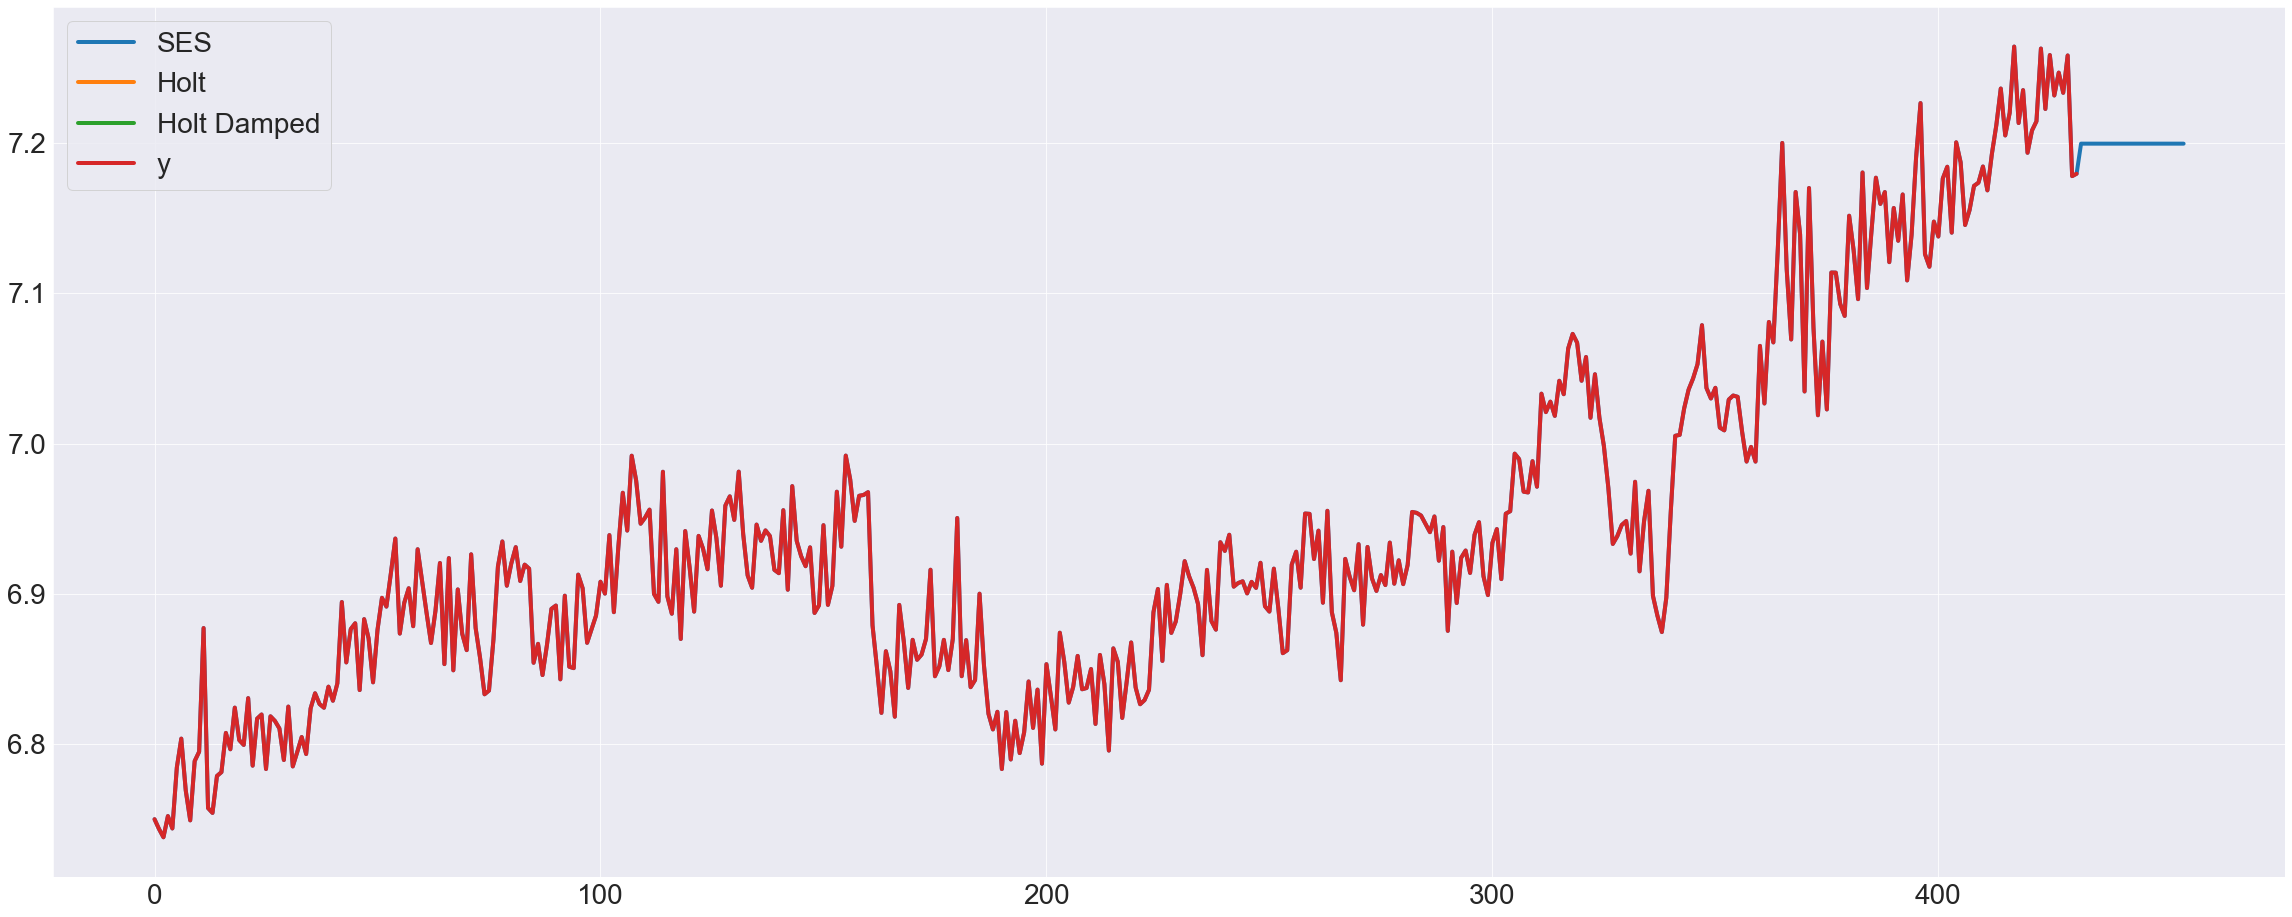

In [5]:
forecasts = pd.DataFrame(index=np.arange(y.shape[0] + 24),columns=["SES","Holt", "Holt Damped", "y"])
forecasts["y"] = np.log(y)
forecasts["SES"] = pd.concat([np.log(y), ses.forecast(24)])
_ = forecasts.plot()

# Holt's Method

Add a second smoother for the trend.

$$
\begin{align*}
\hat{X}_{T+h|T} & =L_{T}+hB_{T}\\
L_{T} & =\alpha X_{T}+\left(1-\alpha\right)\left(L_{T-1}+B_{T-1}\right)\\
B_{T} & =\beta\left(L_{T}-L_{T-1}\right)+\left(1-\beta\right)B_{T-1}
\end{align*}
$$

In [6]:
holt = ExponentialSmoothing(np.log(y), trend=True).fit()
holt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:                   ETS(A, A, N)   Log Likelihood                 875.691
Date:                Wed, 06 May 2020   AIC                          -1741.382
Time:                        17:58:57   BIC                          -1721.040
Sample:                             0   HQIC                         -1733.351
                                - 432   Scale                            0.001
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4417        nan        nan        nan         nan         nan
smoothing_trend     0.0001        nan        nan        nan         nan         nan
initial_level       6.7464        nan        nan        nan         nan         nan
initial_trend       0.0010        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      236.96   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.00   Prob(JB):                         0.68
Heteroskedasticity (H):               1.49   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [7]:
holt.states.filtered

,error,level,trend
0,0.001558,6.748640,0.001050
1,-0.003316,6.747066,0.001049
2,-0.005535,6.743736,0.001048
3,0.004196,6.748105,0.001049
4,-0.002856,6.746894,0.001048
...,...,...,...
427,0.003829,7.242825,0.001061
428,-0.005962,7.239169,0.001060
429,0.009949,7.248100,0.001062
430,-0.039835,7.217644,0.001054


# Holt's with Damping


Add a damping parameter $\phi$ that limits the permanent effect of the final trend.

$$
\begin{align*}
\hat{X}_{T+h|T} & =L_{T}+\left(\phi+\phi^{2}+\ldots+\phi^{h}\right)B_{T}\\
L_{T} & =\alpha X_{T}+\left(1-\alpha\right)\left(L_{T-1}+\phi B_{T-1}\right)\\
B_{T} & =\beta\left(L_{T}-L_{T-1}\right)+\left(1-\beta\right)\phi B_{T-1}
\end{align*}
$$

In [8]:
holt_damped = ExponentialSmoothing(np.log(y), trend=True, damped_trend=True).fit()
holt_damped.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  M3276   No. Observations:                  432
Model:                  ETS(A, Ad, N)   Log Likelihood                 875.364
Date:                Wed, 06 May 2020   AIC                          -1738.729
Time:                        17:58:57   BIC                          -1714.318
Sample:                             0   HQIC                         -1729.092
                                - 432   Scale                            0.001
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.4447        nan        nan        nan         nan         nan
smoothing_trend     0.0001        nan        nan        nan         nan         nan
damping_trend       0.9788        nan        nan        nan         nan         nan
initial_level       6.7402        nan        nan        nan         nan         nan
initial_trend       0.0040        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      238.27   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.00   Prob(JB):                         0.66
Heteroskedasticity (H):               1.51   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [9]:
holt_damped.states.filtered

,error,level,trend
0,0.003398,6.746799,0.003900
1,-0.003813,6.747563,0.003817
2,-0.007273,6.745475,0.003735
3,0.001761,6.750540,0.003656
4,-0.005598,6.749636,0.003577
...,...,...,...
427,0.005092,7.241562,0.000027
428,-0.004655,7.237861,0.000026
429,0.011196,7.246853,0.000028
430,-0.038356,7.216165,0.000020


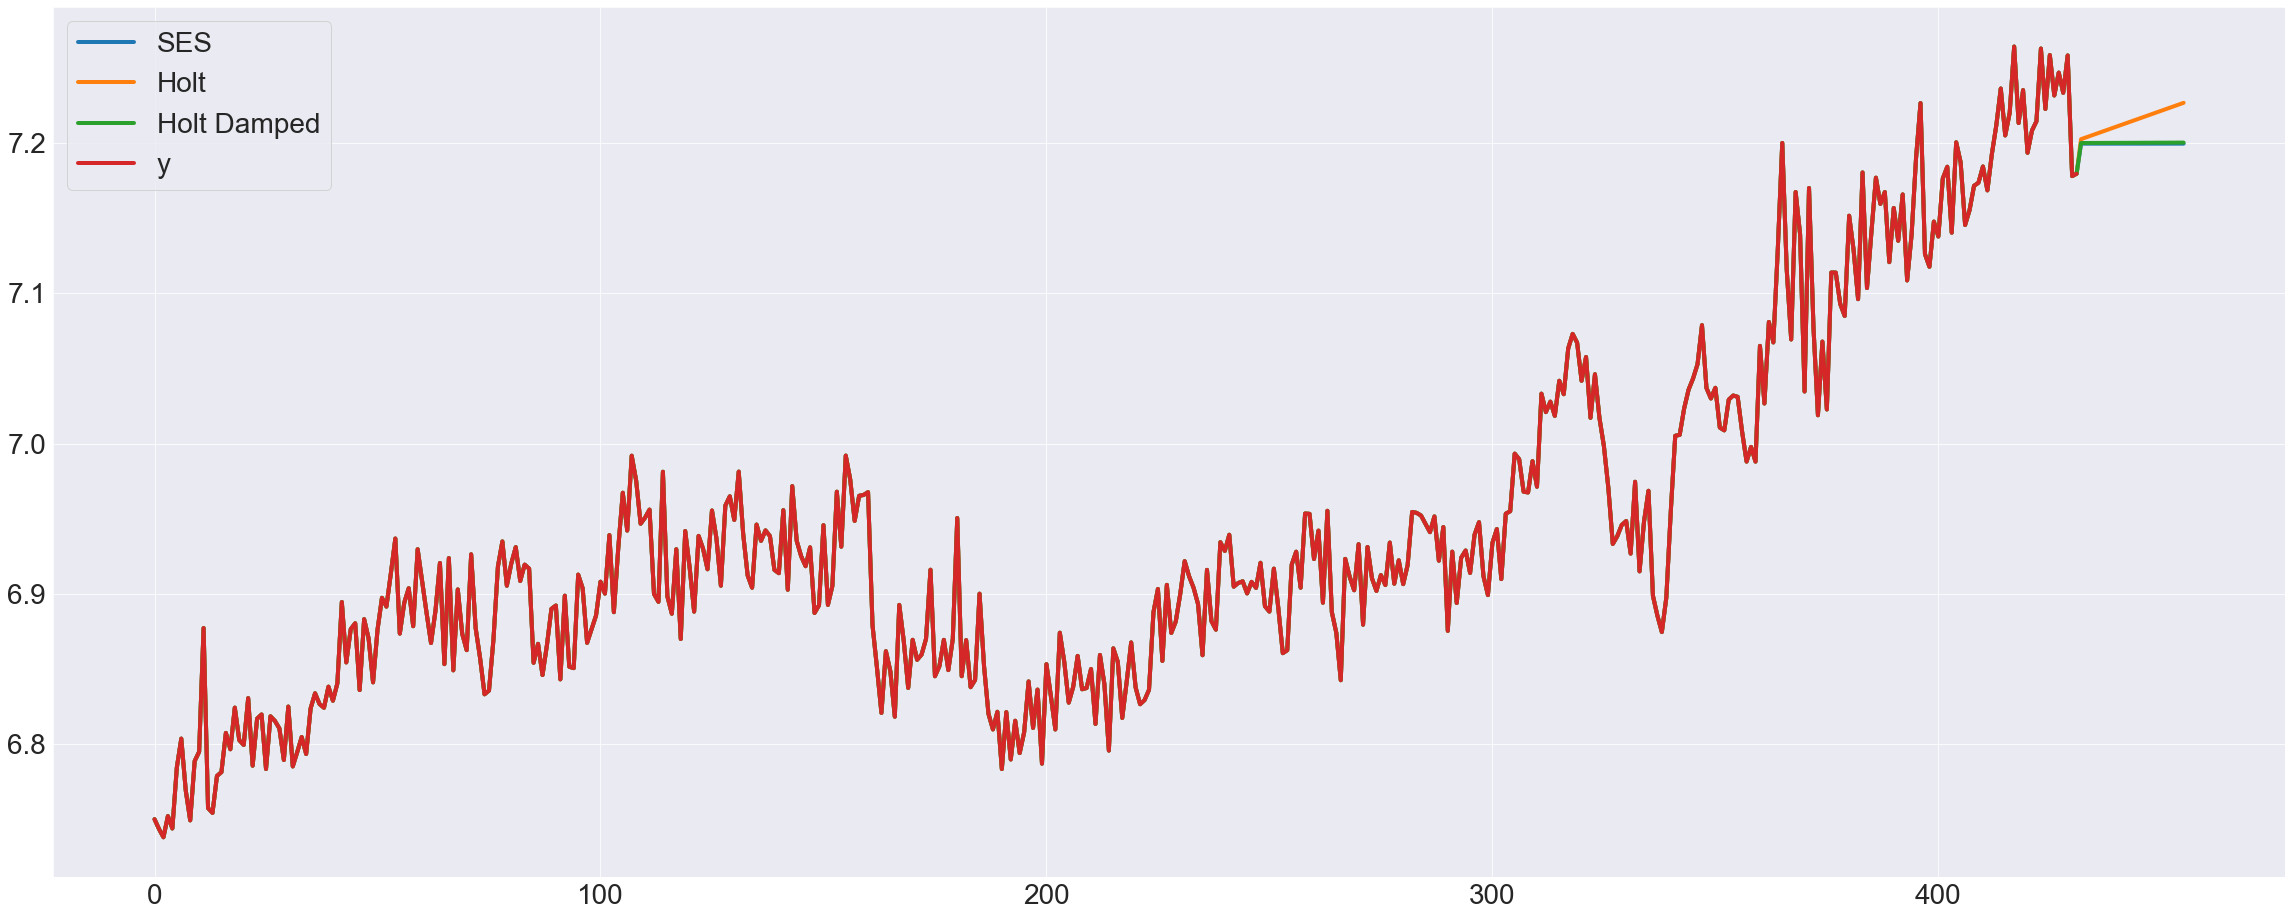

In [10]:
forecasts["Holt"] = pd.concat([np.log(y), holt.forecast(24)])
forecasts["Holt Damped"] = pd.concat([np.log(y), holt_damped.forecast(24)])
_ = forecasts.plot()

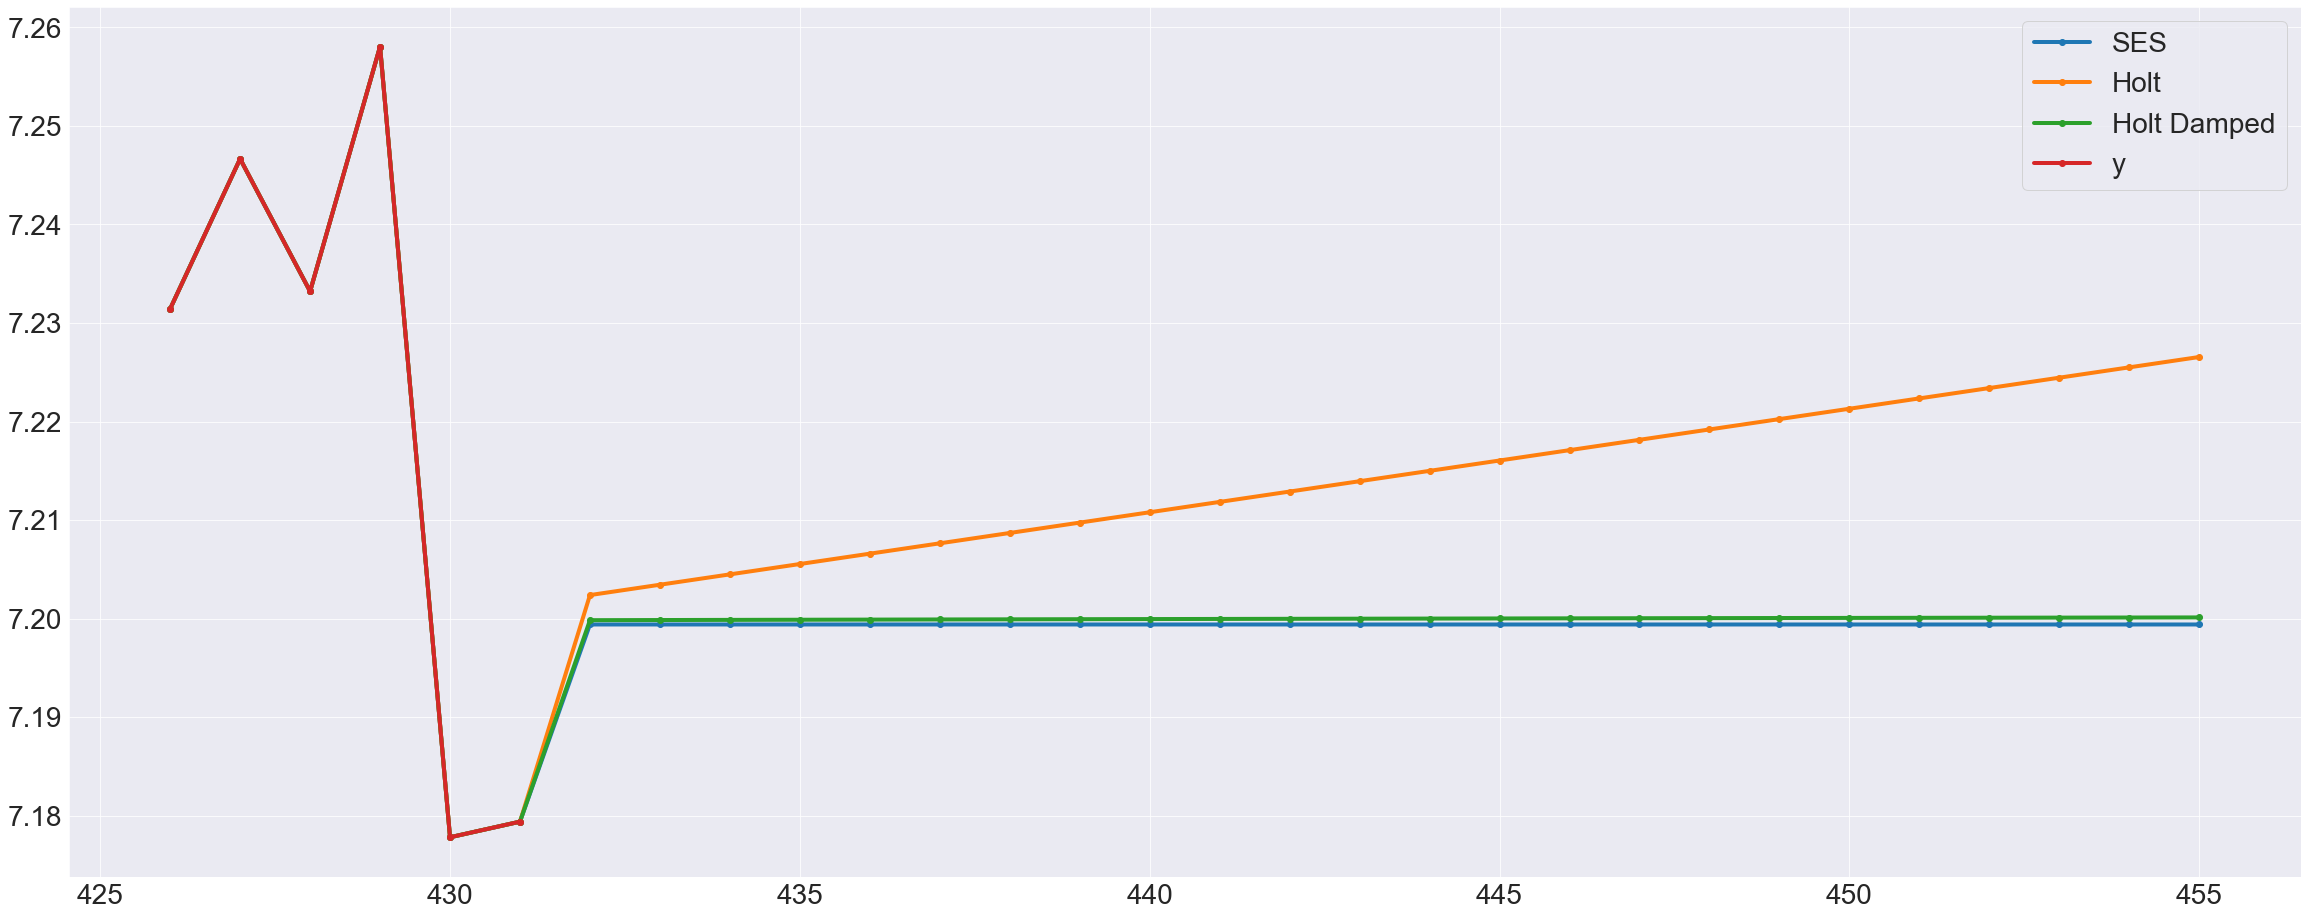

In [11]:
_ = forecasts.tail(30).plot(marker="o")

# Holt-Winters

Adds additional smoothers for $m$ seasonal components.

$$
\begin{align*}
\hat{X}_{T+h|T} & =L_{T}+hB_{T}+S_{T+h-m(k+1)}\\
L_{T} & =\alpha \left(X_{T}-S_{T-m}\right)+\left(1-\alpha\right)\left(L_{T-1}+B_{T-1}\right)\\
B_{T} & =\beta\left(L_{T}-L_{T-1}\right)+\left(1-\beta\right)B_{T-1}\\
S_{T} & =\gamma \left(X_{T}-L_{T-1}-B_{T-1}\right)+\left(1-\gamma\right)S_{T-m}
\end{align*}
$$

In [12]:
y = np.log(x["M25698"])
holt_winters = ExponentialSmoothing(y, trend=True, seasonal =12).fit(maxiter=500)
holt_winters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                 M25698   No. Observations:                  432
Model:                   ETS(A, A, A)   Log Likelihood                 -77.883
Date:                Wed, 06 May 2020   AIC                            189.767
Time:                        17:59:00   BIC                            258.930
Sample:                             0   HQIC                           217.072
                                - 432   Scale                            0.084
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0460        nan        nan        nan         nan         nan
smoothing_trend         0.0001        nan        nan        nan         nan         nan
smoothing_seasonal      0.0001        nan        nan        nan         nan         nan
initial_level           6.8027        nan        nan        nan         nan         nan
initial_trend           0.0013        nan        nan        nan         nan         nan
initial_seasonal.0     -0.0981        nan        nan        nan         nan         nan
initial_seasonal.1     -0.3010        nan        nan        nan         nan         nan
initial_seasonal.2     -0.0032        nan        nan        nan         nan         nan
initial_seasonal.3      0.2303        nan        nan        nan         nan         nan
initial_seasonal.4     -0.3132        nan        nan        nan         nan         nan
initial_seasonal.5     -0.1655        nan        nan        nan         nan         nan
initial_seasonal.6     -0.2415        nan        nan        nan         nan         nan
initial_seasonal.7      0.3509        nan        nan        nan         nan         nan
initial_seasonal.8     -0.0145        nan        nan        nan         nan         nan
initial_seasonal.9      0.5527        nan        nan        nan         nan         nan
initial_seasonal.10     0.1289        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       76.71   Jarque-Bera (JB):               258.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [13]:
ses = ExponentialSmoothing(y, trend=False).fit()
holt = ExponentialSmoothing(y, trend=True).fit(maxiter=500)

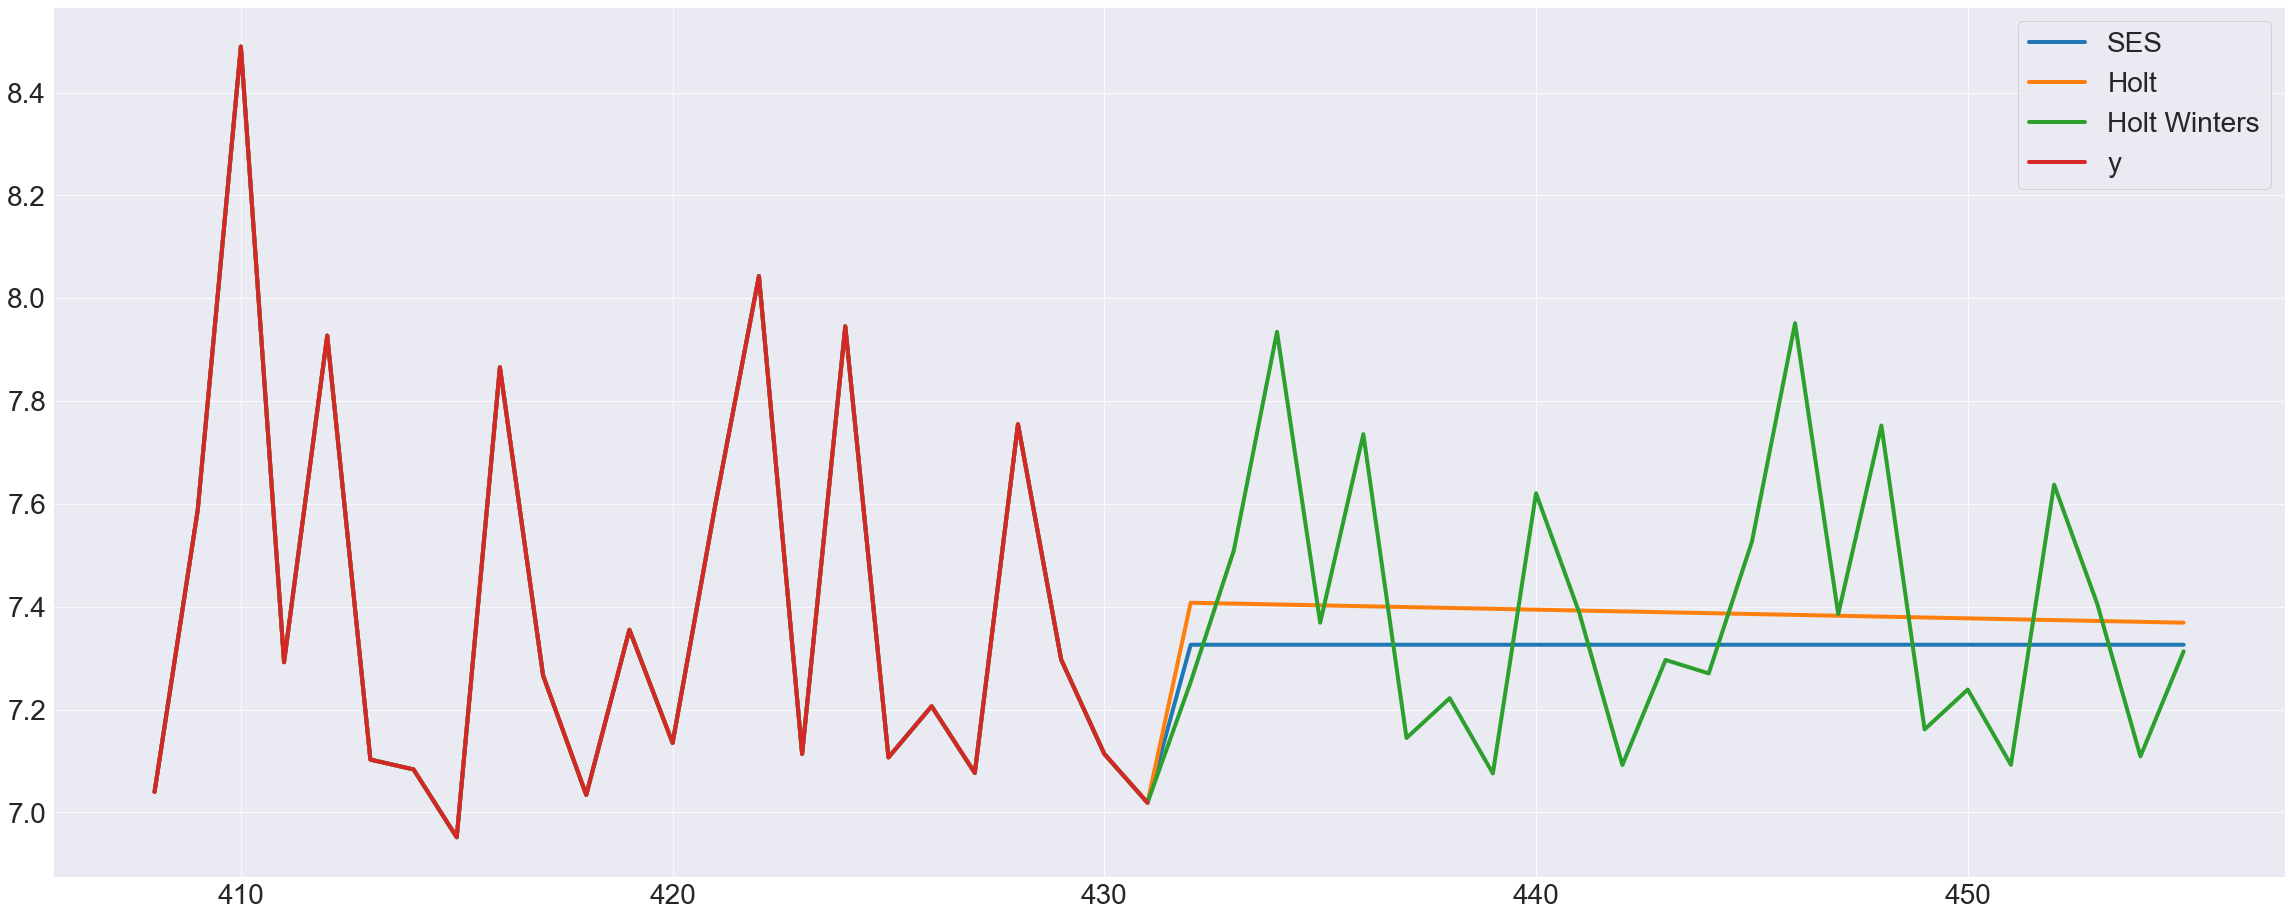

In [14]:
forecasts = pd.DataFrame(index=np.arange(y.shape[0] + 24),columns=["SES","Holt", "Holt Winters", "y"])
forecasts["y"] = y
forecasts["Holt Winters"] = pd.concat([y, holt_winters.forecast(24)])
forecasts["Holt"] = pd.concat([y, holt.forecast(24)])
forecasts["SES"] = pd.concat([y, ses.forecast(24)])
_ = forecasts.tail(48).plot()

# Initial Values

Initial value estimation can be slow, especially in Holt-Winters. Can use an simple "heuristic" to estimate parameters.

In large enough datasets:

* Level and trend are estimated using the first 10 observations and a regression on a constant and a time trend.
* $m$ seasonal effects are estimated from the average value of the demeaned and detrended data in the first 5 complete cycles.

Fitting with `initialization_method="heuristic"` is nearly instantaneous.

In [15]:
holt_winters = ExponentialSmoothing(y, trend=True, seasonal=12, initialization_method="heuristic").fit()
holt_winters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                 M25698   No. Observations:                  432
Model:                   ETS(A, A, A)   Log Likelihood                -151.700
Date:                Wed, 06 May 2020   AIC                            311.400
Time:                        17:59:01   BIC                            327.673
Sample:                             0   HQIC                           317.825
                                - 432   Scale                            0.118
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.0411        nan        nan        nan         nan         nan
smoothing_trend        0.0011        nan        nan        nan         nan         nan
smoothing_seasonal     0.2372        nan        nan        nan         nan         nan
============================================
            initialization method: heuristic
--------------------------------------------
error                                 6.7926
level                                -0.0069
trend                                -0.0369
seasonal.0                            0.3458
seasonal.1                            0.9577
seasonal.2                            0.0414
seasonal.3                            0.1024
seasonal.4                           -0.2856
seasonal.5                           -0.1839
seasonal.6                           -0.3608
seasonal.7                            0.3349
seasonal.8                            0.1206
seasonal.9                           -0.4209
seasonal.10                          -0.6147
===================================================================================
Ljung-Box (Q):                       70.85   Jarque-Bera (JB):               478.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

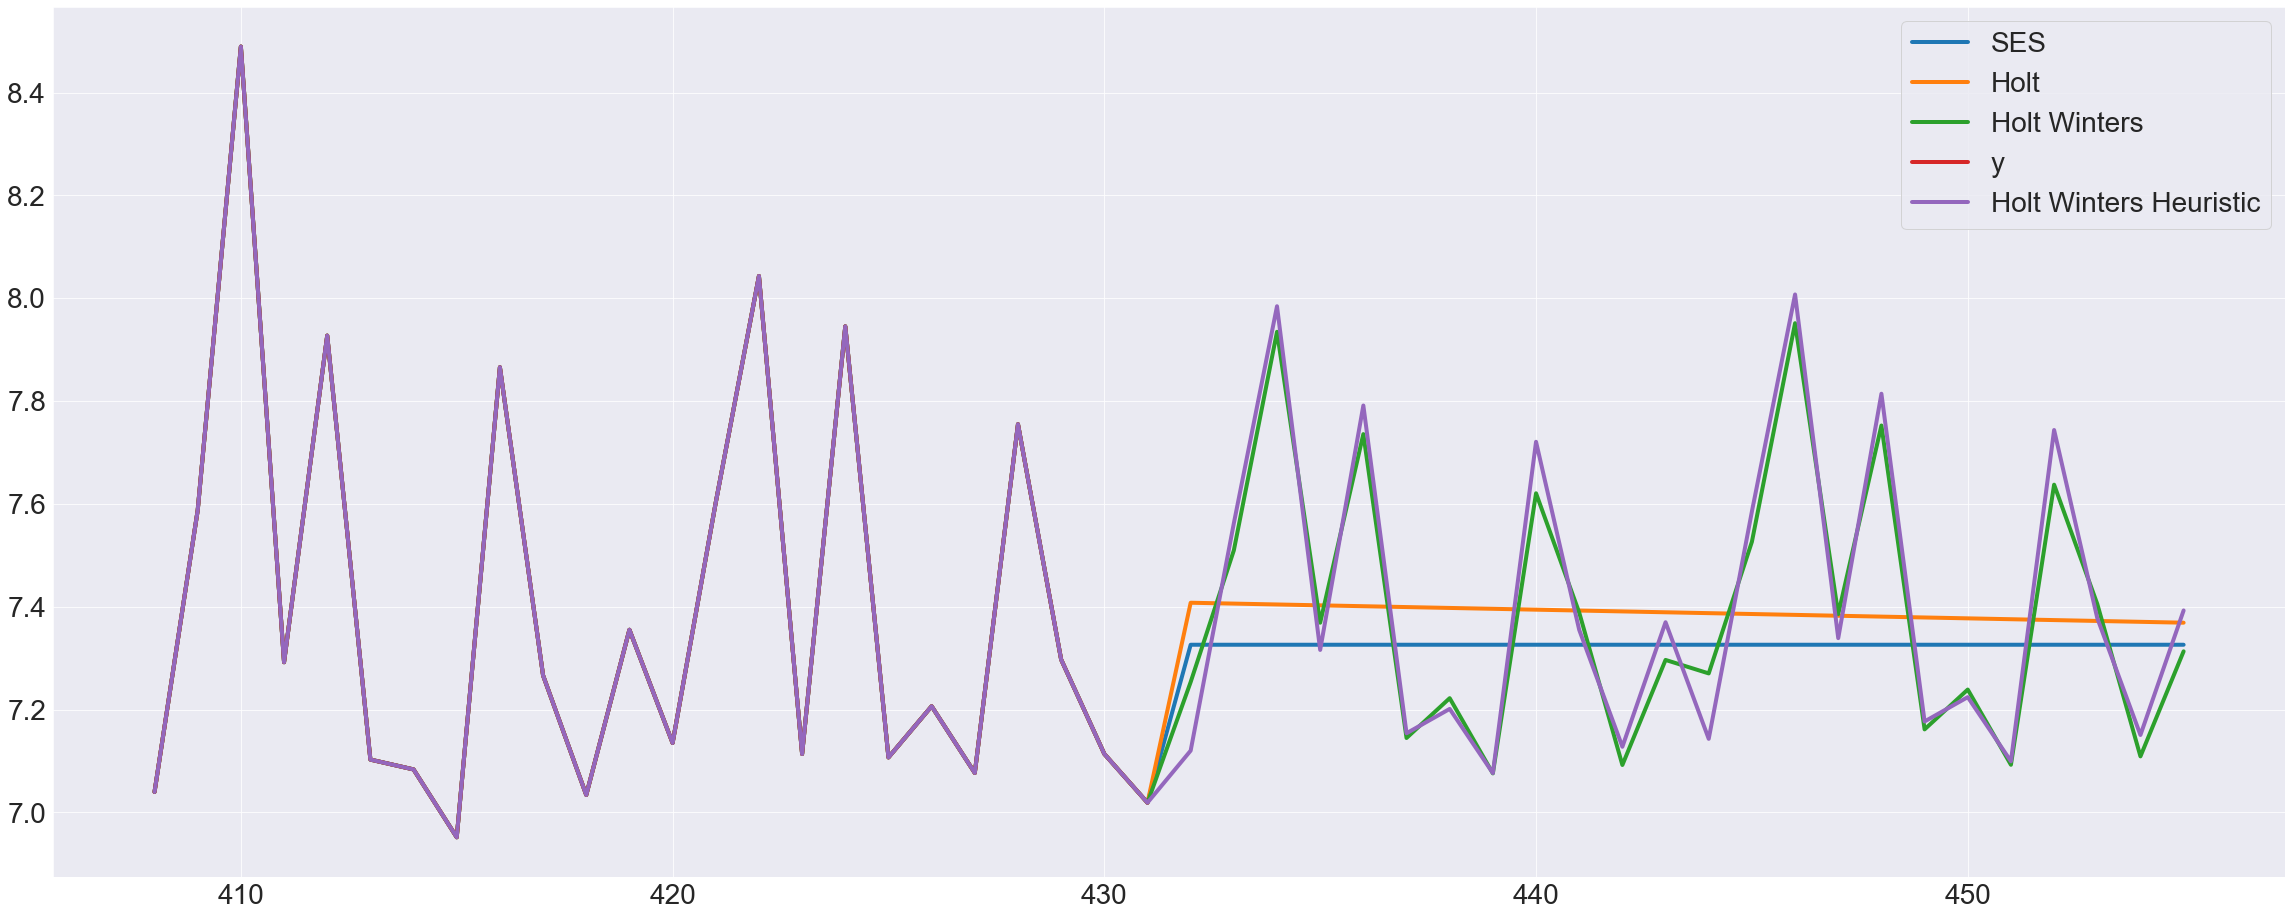

In [16]:
forecasts["Holt Winters Heuristic"] = pd.concat([y, holt_winters.forecast(24)])
_ = forecasts.tail(48).plot()

# Additional Examples

We finally look at `M23579` which is both trending and has a seasonality.

In [17]:
y = np.log(x["M23579"])
ses = ExponentialSmoothing(y).fit()
holt = ExponentialSmoothing(y, trend=True).fit()
holt_damped = ExponentialSmoothing(y, trend=True, damped_trend=True).fit()
holt_winters = ExponentialSmoothing(y, trend=True, seasonal=12).fit(maxiter=250)
holt_winters_damped = ExponentialSmoothing(y, trend=True, seasonal=12, damped_trend=True).fit(maxiter=250)

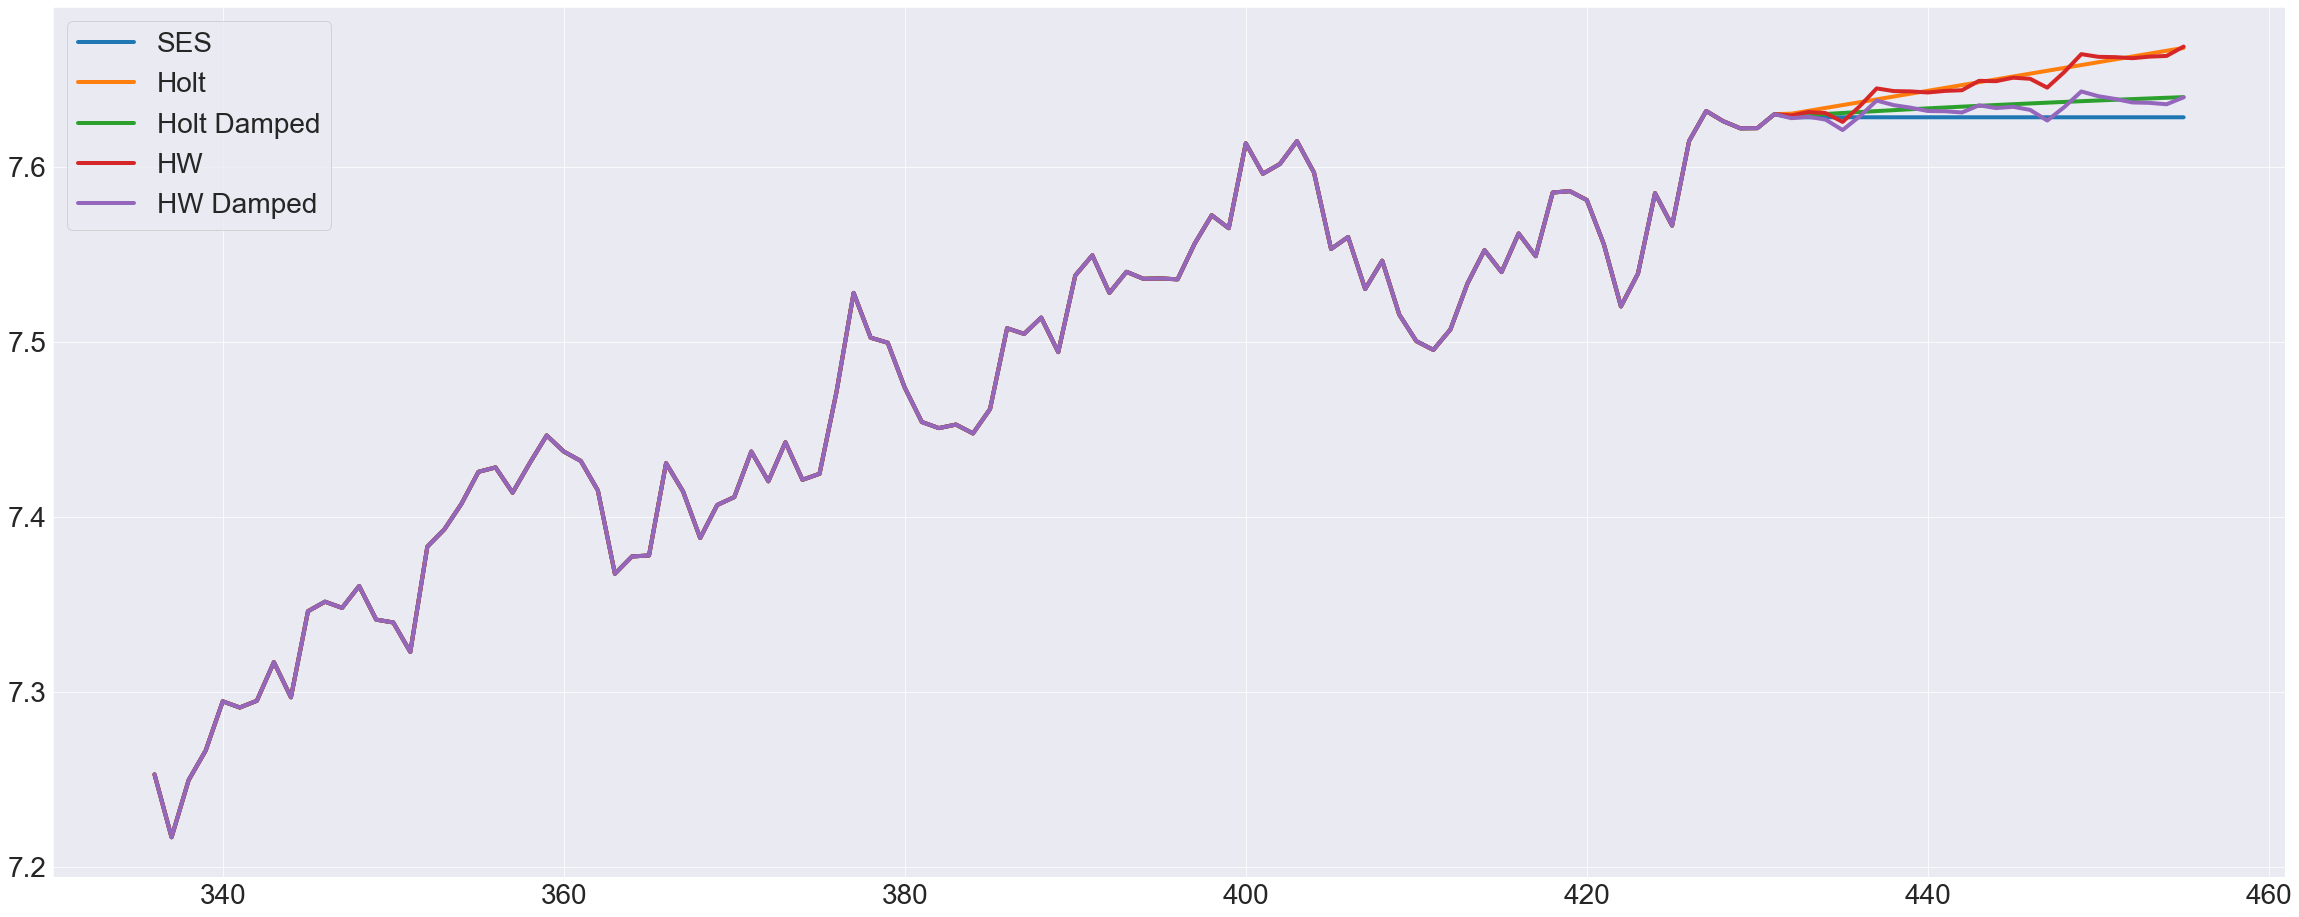

In [18]:
forecasts = pd.DataFrame(index=np.arange(y.shape[0]+24),columns=["SES","Holt","Holt Damped","HW","HW Damped"])

forecasts.iloc[:y.shape[0],:] = pd.concat([y]*5, axis=1).values
idx = forecasts.index[-24:]
forecasts.loc[idx, "SES"] = ses.forecast(24)
forecasts.loc[idx, "Holt"] = holt.forecast(24)
forecasts.loc[idx, "Holt Damped"] = holt_damped.forecast(24)
forecasts.loc[idx, "HW"] = holt_winters.forecast(24)
forecasts.loc[idx, "HW Damped"] = holt_winters_damped.forecast(24)
_ = forecasts.tail(120).plot()

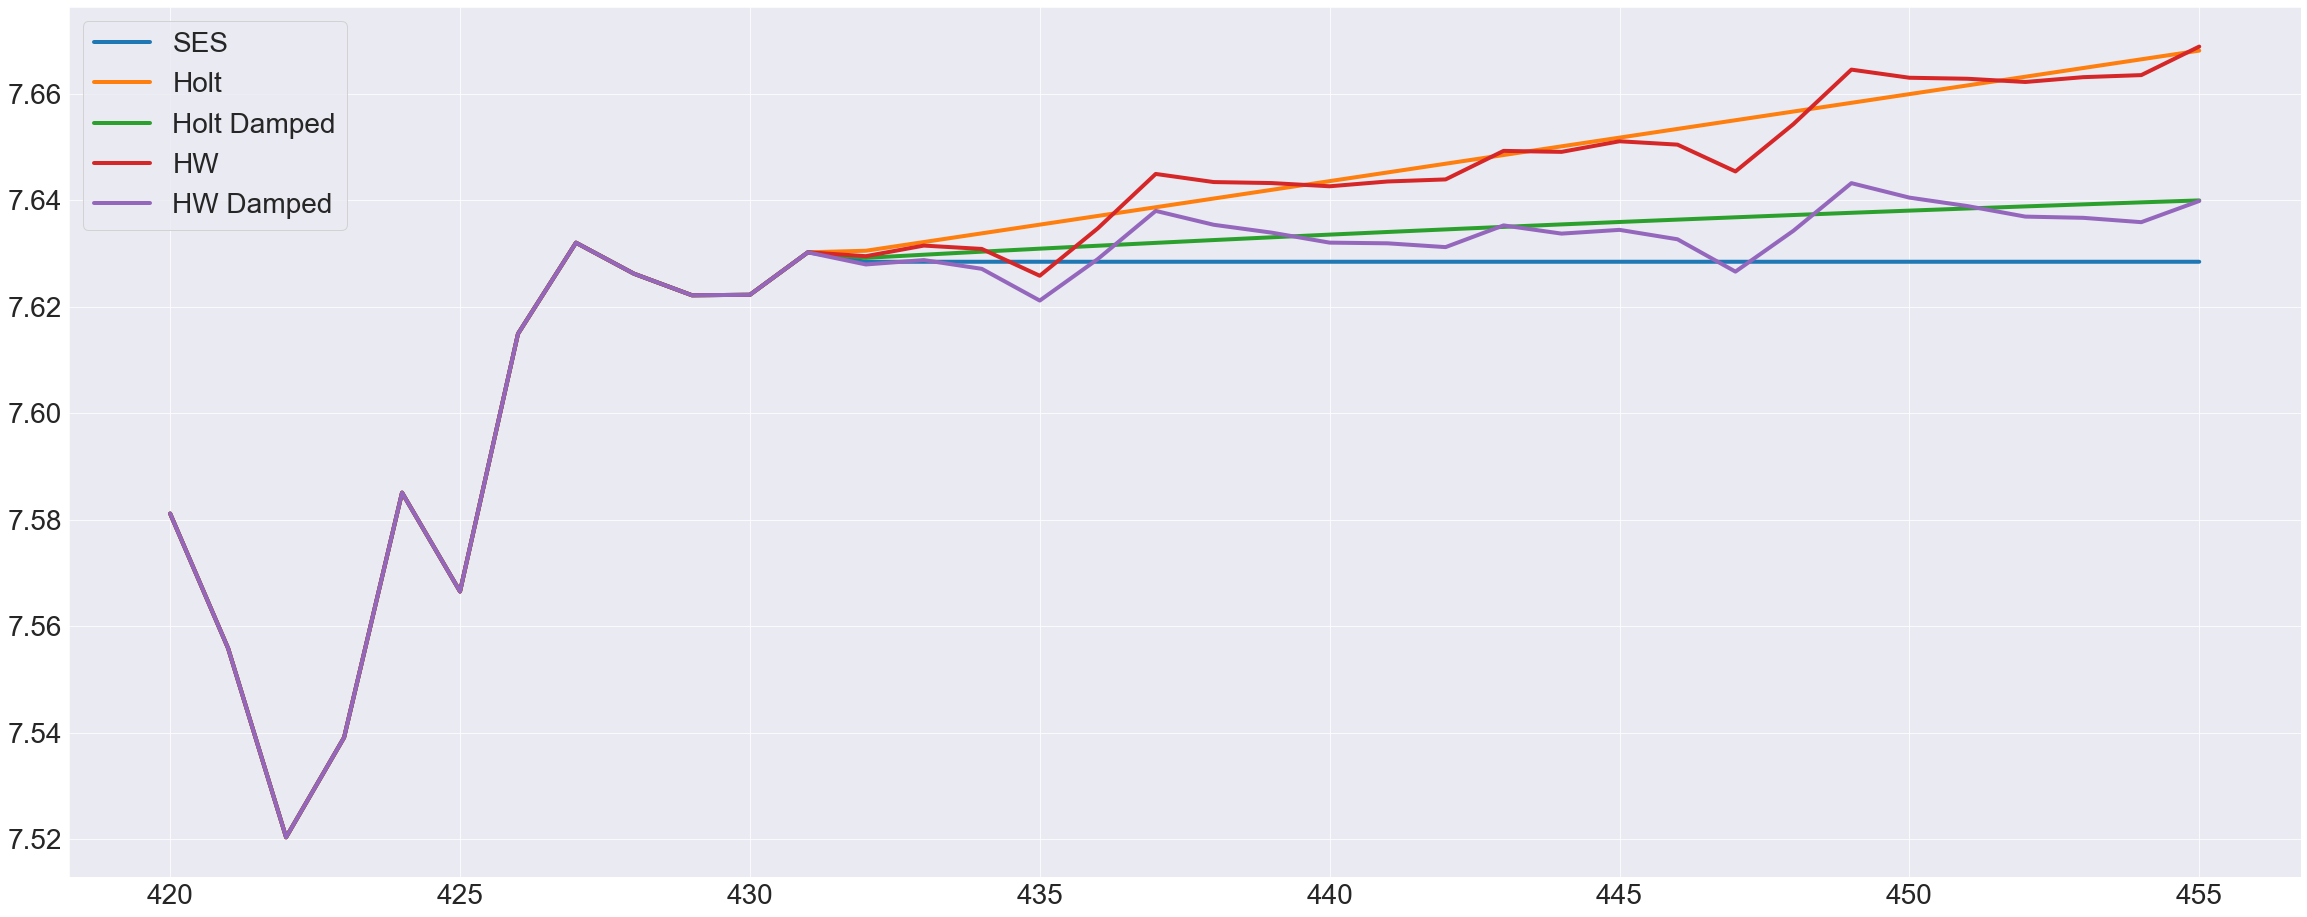

In [19]:
_ = forecasts.tail(36).plot()